In [1]:
import numpy as np
import re 
import string
import pandas as pd
pd.options.display.max_colwidth = 100
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook
from tqdm import tqdm
tqdm.pandas()

tqdm_notebook().pandas()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, RobustScaler,MinMaxScaler,StandardScaler,LabelEncoder

import sklearn.naive_bayes as nb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, classification_report, f1_score,recall_score,precision_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import xgboost as xgb
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


### Eploratory Data

##### Initialise data

In [2]:
# import csv

df_merge_clean_posts = pd.read_csv('df_merge_clean_posts.csv')
df_merge_tfidf = pd.read_csv('df_merge_tfidf.csv')
df_merge_cvn = pd.read_csv('df_merge_cvn.csv')

In [3]:
df_merge_clean_posts.drop('Unnamed: 0',axis=1,inplace=True)
df_merge_tfidf.drop('Unnamed: 0',axis=1,inplace=True)
df_merge_cvn.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
total_users = df_merge_clean_posts.ptype.count()

##### Personality types with one hot encoder
The personality type are labeled with digits 

In [5]:
le = LabelEncoder()
encoder_label = le.fit_transform(df_merge_clean_posts.ptype)

In [6]:
df_merge_clean_posts.insert(1,'ptype_label',encoder_label)
df_merge_tfidf.insert(1,'ptype_label',encoder_label)

##### Personality types comparison
We can see that the personality types are really unbalanced. 
It is also observed that the IN++ type personality takes the top 4 spots
The majority is INFP at 21.2%. This percentage will be our baseline for accuracy score

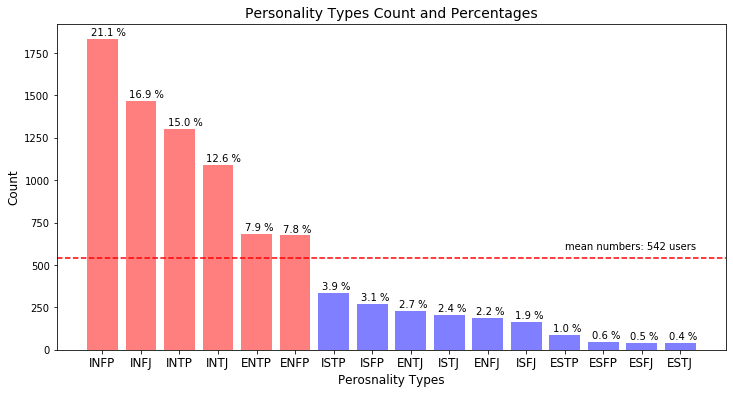

In [7]:
# number of each personality type
plt.figure(figsize=(12,6))
temp = df_merge_clean_posts.ptype.value_counts().sort_values(ascending=False)

plt.bar(temp.index,temp.values,color=['r','r','r','r','r','r','b','b','b','b','b','b','b','b','b','b'],alpha=0.5)

plt.xticks(temp.index,rotation=0,fontsize=12);
plt.title('Personality Types Count and Percentages',fontsize=14)
plt.ylabel('Count',fontsize=12)
plt.xlabel('Perosnality Types',fontsize=12)

plt.text(12,temp.values.mean()+50,'mean numbers: {0:.0f} users'.format( temp.values.mean()))
plt.axhline(temp.values.mean(),color='r',linestyle='--',label ='mean')

for i in range(len(temp.index)):
    plt.annotate( '{0:.1f} %'.format(100*temp.values[i]/total_users) ,  # percentage
                 (i-.3,temp.values[i]+20))
#     plt.annotate( '%',  # percentage
#                  (i+.3,temp.values[i]+3))

##### Personality Dichotomy Percentages
When we the type dichotomy, the ratio for Extrovert vs Introvert and Intuition vs Sensing is unbalanced (here we defined unbalanced as more than 1:4 ratio or 25%:75%) .  

In [8]:
world_E = df_merge_clean_posts.world_E_I.sum()
information_S = sum(df_merge_clean_posts.information_S_N)
decision_T = sum(df_merge_clean_posts.decision_T_F)
structure_J = sum(df_merge_clean_posts.structure_J_P)

pchar = {'world_I' : total_users-world_E,
         'world_E' : world_E, 
         'information_N': total_users-information_S,
         'information_S' : information_S,
         'decision_F': total_users-decision_T, 
         'decision_T' : decision_T,
         'structure_P': total_users-structure_J,
         'structure_J' : structure_J, }

In [9]:
pchar = pd.DataFrame.from_dict(pchar,orient='index',columns=['pchar'])
pchar['percentage'] = pchar.pchar.apply(lambda x: x/total_users)

In [10]:
pchar

,pchar,percentage
world_I,6676,0.769568
world_E,1999,0.230432
information_N,7478,0.862017
information_S,1197,0.137983
decision_F,4694,0.541095
decision_T,3981,0.458905
structure_P,5241,0.604150
structure_J,3434,0.395850


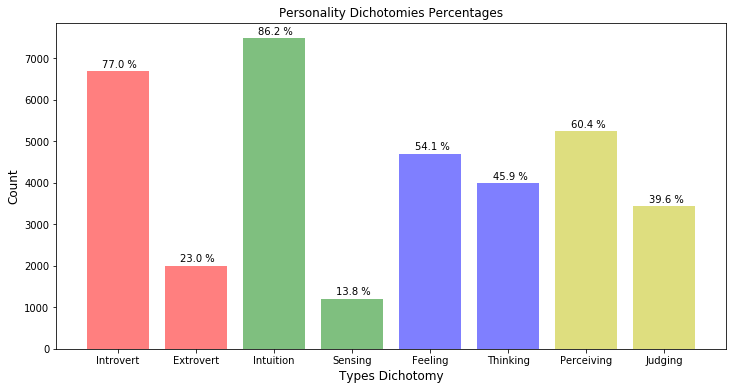

In [11]:
plt.figure(figsize=(12,6))
plt.bar(pchar.index,pchar.pchar,color=['r','r','g','g','b','b','y','y'],alpha=.5)

plt.xticks(pchar.index,['Introvert','Extrovert','Intuition','Sensing',
                        'Feeling','Thinking','Perceiving','Judging'])
plt.title('Personality Dichotomies Percentages')
plt.ylabel('Count',fontsize=12)
plt.xlabel('Types Dichotomy',fontsize=12)


for i in range(len(pchar.index)):
    plt.annotate( '{0:.1f} %'.format(100*pchar.percentage[i]) ,  # percentage
                 (i-.2,pchar.pchar.values[i]+100))

### Clean Post comparison
We break down the featues in the clean posts dataframe into 3 feature groups 
1. Subjectivity and Polarity    
2. Function words   
3. Word counts

Unfortuantely, We do not find significance differences accross the personlity types on Subjectivity and Polarity and Word Count. But We do see some features with the function words have a differential range between 5 - 10 %.
Intuitively, we probably not see any siginificant accuracy results 

##### Subjectivity and Polarity Comparison

In [12]:
df_merge_clean_posts.columns

Index(['ptype', 'ptype_label', 'world_E_I', 'information_S_N', 'decision_T_F',
       'structure_J_P', 'clean_posts', 'polarity', 'subjectivity',
       'conjunction', 'determiner', 'verb_aux', 'personal_pron',
       'possessive_pron', 'verb', 'function_word_count', 'word_count',
       'num_of_entries', 'avg_words_post'],
      dtype='object')

In [13]:
df_merge_clean_posts.groupby('ptype')['polarity', 'subjectivity'].agg(['mean','std'])

polarity           subjectivity          
           mean       std         mean       std
ptype                                           
ENFJ   0.148847  0.058732     0.538579  0.039702
ENFP   0.137147  0.057040     0.538521  0.038671
ENTJ   0.120511  0.054475     0.525913  0.039602
ENTP   0.116371  0.051273     0.529699  0.039297
ESFJ   0.143048  0.051020     0.533000  0.036801
ESFP   0.113083  0.056911     0.535708  0.046290
ESTJ   0.117872  0.050423     0.523487  0.043646
ESTP   0.118213  0.051019     0.527618  0.045973
INFJ   0.125999  0.052026     0.529203  0.038713
INFP   0.121611  0.053390     0.532937  0.040903
INTJ   0.109291  0.053908     0.521378  0.041478
INTP   0.102514  0.053035     0.521051  0.039665
ISFJ   0.126283  0.095461     0.534687  0.062397
ISFP   0.131952  0.061178     0.533026  0.043422
ISTJ   0.114215  0.062272     0.516668  0.038433
ISTP   0.106196  0.062485     0.517493  0.053926

##### Function Words comparison

In [14]:
df_merge_clean_posts.groupby('ptype')['conjunction', 'determiner', 'verb_aux', 'personal_pron',
                                      'possessive_pron', 'verb', 'function_word_count'].agg(['mean','std'])

conjunction            determiner              verb_aux            \
             mean        std       mean        std       mean       std   
ptype                                                                     
ENFJ    48.615789  16.885696  91.300000  24.415051  17.605263  7.127484   
ENFP    48.525926  15.965295  91.118519  25.888271  17.517037  7.071126   
ENTJ    42.783550  14.581581  93.705628  26.532997  17.787879  7.258760   
ENTP    43.821898  14.523940  92.310949  25.365825  17.557664  6.797507   
ESFJ    48.309524  16.129791  95.071429  28.570318  17.785714  7.915825   
ESFP    39.041667  18.996034  74.500000  30.903419  14.354167  6.892764   
ESTJ    46.384615  19.807781  87.641026  24.942552  17.641026  6.599391   
ESTP    43.977528  17.559624  84.033708  25.433268  16.348315  6.775794   
INFJ    47.318367  15.770197  93.783673  25.770063  17.804762  6.884883   
INFP    47.437773  16.288143  90.893013  26.270128  17.275109  7.052171   
INTJ    42.349221  15.496136  92.029331  28.626943  17.833181  7.501048   
INTP    42.873466  15.219754  92.417945  27.480311  17.823620  6.982350   
ISFJ    47.240964  17.346445  88.186747  28.881703  17.771084  7.153427   
ISFP    43.571956  18.218870  79.808118  27.141060  15.527675  7.120534   
ISTJ    42.760976  15.864513  90.785366  28.281893  16.751220  7.511531   
ISTP    42.439169  15.731471  88.821958  28.166243  16.267062  7.293173   

      personal_pron            possessive_pron                 verb  \
               mean        std            mean       std       mean   
ptype                                                                 
ENFJ     162.110526  50.537360        0.363158  0.809801  79.531579   
ENFP     156.594074  46.740536        0.447407  0.810615  75.634074   
ENTJ     141.138528  43.793764        0.229437  0.505792  75.787879   
ENTP     139.472993  42.847492        0.335766  0.689068  73.855474   
ESFJ     161.547619  52.067125        0.357143  0.655983  76.500000   
ESFP     123.250000  54.933809        0.187500  0.445127  61.291667   
ESTJ     147.564103  47.451246        0.179487  0.451419  77.000000   
ESTP     137.303371  47.602856        0.213483  0.553335  72.898876   
INFJ     155.200680  46.961159        0.368707  0.718406  77.524490   
INFP     152.191594  47.910004        0.331332  0.777862  74.223799   
INTJ     136.243813  45.906958        0.267644  0.548432  73.677360   
INTP     137.625000  45.057426        0.245399  0.549522  74.093558   
ISFJ     154.542169  53.444233        0.265060  0.552336  77.006024   
ISFP     140.601476  52.157417        0.261993  0.721106  68.210332   
ISTJ     143.541463  50.531532        0.248780  0.561476  75.687805   
ISTP     137.332344  47.608797        0.255193  0.517703  73.192878   

                 function_word_count              
             std                mean         std  
ptype                                             
ENFJ   23.490098          319.994737   86.643312  
ENFP   22.284731          314.202963   83.352503  
ENTJ   23.281697          295.645022   80.820491  
ENTP   20.695251          293.499270   77.072014  
ESFJ   28.397226          323.071429   98.054339  
ESFP   24.692973          251.333333  102.358222  
ESTJ   21.437793          299.410256   84.634732  
ESTP   24.980012          281.876404   86.804616  
INFJ   22.618068          314.476190   83.032577  
INFP   22.647059          308.128821   85.637034  
INTJ   23.556382          288.723190   85.138325  
INTP   22.733779          290.985429   82.289275  
ISFJ   25.488797          308.006024   97.450687  
ISFP   24.768335          279.771218   94.576910  
ISTJ   24.961345          294.087805   91.410473  
ISTP   24.320312          285.115727   88.237108

##### Word Count comparison

In [15]:
df_merge_clean_posts.groupby('ptype')['word_count','num_of_entries', 'avg_words_post'].agg(['mean','std'])

word_count             num_of_entries           avg_words_post  \
              mean         std           mean       std           mean   
ptype                                                                    
ENFJ   1581.584211  378.366610      45.031579  6.683238      34.294737   
ENFP   1557.554074  363.077100      44.785185  6.992986      34.010370   
ENTJ   1493.463203  348.737720      44.311688  6.681434      32.952381   
ENTP   1480.207299  341.494755      44.702190  5.625917      32.329927   
ESFJ   1580.238095  428.197288      45.190476  7.188195      33.976190   
ESFP   1271.104167  487.806346      40.354167  9.785986      30.229167   
ESTJ   1497.358974  366.553973      44.512821  7.192364      32.923077   
ESTP   1420.224719  392.559600      43.426966  7.704614      31.831461   
INFJ   1566.808844  364.054860      44.540136  6.725946      34.382993   
INFP   1523.703603  376.552935      43.793668  7.188650      33.950873   
INTJ   1464.468378  384.338208      43.521540  7.847997      32.810266   
INTP   1467.889571  369.903798      43.797546  7.319617      32.706288   
ISFJ   1526.084337  436.289248      43.783133  8.511736      33.680723   
ISFP   1400.014760  421.698286      41.785978  8.883940      32.583026   
ISTJ   1490.439024  401.068050      43.185366  8.404293      33.863415   
ISTP   1430.774481  396.769098      43.320475  7.534324      32.097923   

                 
            std  
ptype            
ENFJ   5.639756  
ENFP   4.996279  
ENTJ   4.685072  
ENTP   5.264001  
ESFJ   6.361040  
ESFP   7.152561  
ESTJ   4.836183  
ESTP   5.341169  
INFJ   4.966421  
INFP   5.106489  
INTJ   5.126091  
INTP   5.032245  
ISFJ   5.775643  
ISFP   5.695314  
ISTJ   5.728402  
ISTP   5.805316

### Modelling with Personality types

Selected Classification Models:
- Logistic Regression
- Random Forest
- K Nearest Neighbours
- Naive Bayes 

Results:
- From the selected classifer models with basic hyper tuning, Logistic Regression scored the highest just .1% higher than the next model, Random Forest Classifier.
- Accuracy score obtained from clean post dataset score slightly higher than from TF-IDF dataset. This is good news. Because relying on text used is very specific to the content and user's background. On the other hand, the use of pronouns are more encompassing over different topics.
- From the confusion, we can clearly see that the best model is leaning towards the majority group, the minority groups are simply ignored. Even within the majority group, the accuracy varies greatly. We could possibly infer that the model is simply 'guessing'.

##### Multi class scoring

In [16]:
def multiclass_score(X_train, X_test, y_train, y_test):

    param_grid = dict(n_neighbors=[15,30,50], 
                      weights=['uniform','distance'], 
                      metric=['euclidean','manhattan'])
    
    grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy',return_train_score=True)
    grid.fit(X_train, y_train)
    print('K Nearest Neighbour best param: ',grid.best_params_)
    print('K Nearest Neighbour acc score: {0:.2f} %'.format(grid.best_score_*100))
        
    
    param_grid = dict(penalty =['l1','l2'], 
                      C= np.logspace(0, 4, 10))
                      
    grid = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='accuracy',return_train_score=True)
    grid.fit(X_train, y_train)
    print('Logistic Regression best param: ',grid.best_params_)
    print('Logistic Regression acc score: {0:.2f} %'.format(grid.best_score_*100))

    
    param_grid = dict(n_estimators= [100,200],
                      max_depth = [5,10],
                      max_features= ['auto', 'sqrt', 'log2'])
            
    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy',return_train_score=True)
    grid.fit(X_train, y_train)
    print('Random Forest best param: ',grid.best_params_)
    print('Random Forest acc score: {0:.2f} %'.format(grid.best_score_*100))

    
    gb = nb.GaussianNB()
    gb.fit(X_train,y_train)
    pred_y = gb.predict(X_test)
    print('Gaussian Naive Bayes score: {0:.2f} %'.format(gb.score(X_test,y_test)*100))
    test = gb.predict_proba(X_test) 
    
    bn = nb.BernoulliNB()
    bn.fit(X_train,y_train)
    pred_y = bn.predict(X_test)
    print('Bernoulli Naive Bayes score: {0:.2f} %'.format(bn.score(X_test,y_test)*100))
    


In [17]:
def cm_df(estimater,X_train, X_test, y_train, y_test):
    classifier = estimater
    classifier.fit(X_train,y_train)

    pred_y = classifier.predict_proba(X_test) 

    x=[]
    for i in pred_y:
        x.append(i.argmax())

    temp=pd.DataFrame(confusion_matrix(y_test,x),columns=le.classes_,index=le.classes_)
    temp['total'] = temp.sum(axis=1)
    temp['correct'] = np.diagonal(temp)           #correct predictions are along the diagonal
    temp['accuracy'] = temp.correct/temp.total
    print ('Accuracy score: {}'.format(temp.correct.sum()/temp.total.sum()))

    return temp

##### Clean Post Scoring

In [18]:
df_merge_clean_posts.loc[df_merge_clean_posts['ptype_label'] == 15]

,ptype,ptype_label,world_E_I,information_S_N,decision_T_F,structure_J_P,clean_posts,polarity,subjectivity,conjunction,determiner,verb_aux,personal_pron,possessive_pron,verb,function_word_count,word_count,num_of_entries,avg_words_post
40,ISTP,15,0,1,1,0,I got from what I have read about the enneagram I am a though I read somewhere that a ...,0.161,0.515,39,137,23,200,0,88,399,1835,47,39.0
73,ISTP,15,0,1,1,0,I am only a mystery to myself hugs from my daughter can not get enough hugs from my wIfe lovIng ...,0.133,0.496,38,89,10,98,0,59,235,1249,46,27.0
104,ISTP,15,0,1,1,0,my frIend was tell a few of us about a guy she had recently slept wIth the guy lIked It when she...,0.095,0.471,35,85,7,122,0,53,249,1203,46,26.0
114,ISTP,15,0,1,1,0,nobody Is the same so realIstIcally It Is ImpossIble to base anyone off of stereotypes every...,0.092,0.565,57,115,13,126,0,69,311,1626,47,34.0
123,ISTP,15,0,1,1,0,I do not offer advIce unless It Is asked for or specIfIcally requested and I expect people to do...,0.072,0.524,27,85,14,140,0,85,266,1288,44,29.0
174,ISTP,15,0,1,1,0,I know thIs feelIng bro for example today I went to an awesome bIkIng track wIth small hIlls her...,0.163,0.577,55,91,14,146,0,70,306,1483,44,33.0
188,ISTP,15,0,1,1,0,sIr are you hIgh wow you are pretty sucessfull person beIng ceo wIth employees are quIte som...,0.082,0.551,53,67,12,138,0,88,270,1573,47,33.0
236,ISTP,15,0,1,1,0,raInquIlIty w w w the thInker spso the castle defender vIrgo w w w the ambassador sxsp ...,0.156,0.547,17,29,7,55,0,31,108,650,32,20.0
254,ISTP,15,0,1,1,0,welcome to the forums and are verrrrry dIfferent types luckIly there Is a whole bunch of resou...,0.075,0.590,41,73,12,124,0,60,250,1364,47,29.0
303,ISTP,15,0,1,1,0,started learnIng how to surf a few months ago d Insert complIcated solutIon to a problem her...,0.079,0.519,44,112,17,169,0,68,342,1777,46,38.0


In [19]:
y=df_merge_clean_posts['ptype_label']
X = df_merge_clean_posts.iloc[:,7:]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=42)


scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
#Cross validate using random forest
rf = RandomForestClassifier(n_estimators=100,max_depth=5)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
accuracy_score(pred,y_test)
cross_validate(rf, X_train,y_train)['test_score'].mean()

0.2319272254029546

In [22]:
# Scoring with different models
multiclass_score(X_train, X_test, y_train, y_test)

K Nearest Neighbour best param:  {'metric': 'euclidean', 'n_neighbors': 50, 'weights': 'distance'}
K Nearest Neighbour acc score: 22.19 %
Logistic Regression best param:  {'C': 1.0, 'penalty': 'l1'}
Logistic Regression acc score: 23.74 %
Random Forest best param:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest acc score: 23.74 %
Gaussian Naive Bayes score: 18.13 %
Bernoulli Naive Bayes score: 20.51 %


In [23]:
cm_df(LogisticRegression(),X_train,X_test,y_train,y_test)

Accuracy score: 0.24423963133640553


,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,total,correct,accuracy
ENFJ,0,0,0,0,0,0,0,0,9,18,1,0,0,0,0,0,28,0,0.000000
ENFP,0,1,0,0,0,0,0,0,18,65,2,15,0,0,0,0,101,1,0.009901
ENTJ,0,0,0,0,0,0,0,0,3,19,1,12,0,0,0,0,35,0,0.000000
ENTP,0,0,0,0,0,0,0,0,13,51,2,37,0,0,0,0,103,0,0.000000
ESFJ,0,0,0,0,0,0,0,0,2,4,0,0,0,0,0,0,6,0,0.000000
ESFP,0,0,0,0,0,0,0,0,0,3,0,4,0,0,0,0,7,0,0.000000
ESTJ,0,0,0,0,0,0,0,0,1,5,0,0,0,0,0,0,6,0,0.000000
ESTP,0,0,0,0,0,0,0,0,1,6,0,6,0,0,0,0,13,0,0.000000
INFJ,0,1,0,0,0,0,0,0,41,141,7,31,0,0,0,0,221,41,0.185520
INFP,0,0,0,0,0,0,0,0,47,185,7,36,0,0,0,0,275,185,0.672727


##### TFIDF Scoring

In [24]:
y=df_merge_tfidf['ptype_label']
X = df_merge_tfidf.iloc[:,7:]

In [25]:
scaler=MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# multiclass_score(X_train, X_test, y_train, y_test)

In [26]:
cm_df(LogisticRegression(),X_train, X_test, y_train, y_test)

Accuracy score: 0.23348694316436253


,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,total,correct,accuracy
ENFJ,0,0,0,0,0,0,0,0,6,21,1,0,0,0,0,0,28,0,0.000000
ENFP,0,0,0,0,0,0,0,0,11,75,0,15,0,0,0,0,101,0,0.000000
ENTJ,0,0,0,0,0,0,0,0,2,21,1,11,0,0,0,0,35,0,0.000000
ENTP,0,0,0,0,0,0,0,0,10,54,1,38,0,0,0,0,103,0,0.000000
ESFJ,0,0,0,0,0,0,0,0,2,4,0,0,0,0,0,0,6,0,0.000000
ESFP,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,7,0,0.000000
ESTJ,0,0,0,0,0,0,0,0,1,5,0,0,0,0,0,0,6,0,0.000000
ESTP,0,0,0,0,0,0,0,0,1,6,0,6,0,0,0,0,13,0,0.000000
INFJ,0,0,0,0,0,0,0,0,25,163,3,30,0,0,0,0,221,25,0.113122
INFP,0,0,0,0,0,0,0,0,38,198,3,36,0,0,0,0,275,198,0.720000


### Oversampling clean posts
Here We'll see if the score can be improved with oversampling the train set to get a better prediction on the test set.

In [27]:
y=df_merge_clean_posts['ptype_label']
X = df_merge_clean_posts.iloc[:,7:]

In [28]:
# Train test split on the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=42)

scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape

(7373, 12)

##### Cross Validate
To cross validate the train set with oversampling function, the following are the steps applied
1. Stratify and split the train set into 5 folds. 
2. Loop through each fold. Within each fold, the trainX and trainY is oversampled.
3. Train the model with the oversampled set.
4. Predict the testX 
5. Score it against testY

In [29]:
X_train = pd.DataFrame(X_train,) 
y_train = pd.DataFrame(y_train)

In [30]:
# Train test split on train sets

X_train = pd.DataFrame(X_train) 
y_train = pd.DataFrame(y_train)

kf = StratifiedKFold(5, random_state=42)

for trainIdx, evalIdx in kf.split(X_train,y_train):
    
    trainX, testX = X_train.iloc[trainIdx], X_train.iloc[evalIdx]
    trainY, testY = y_train.iloc[trainIdx], y_train.iloc[evalIdx]
    
    #Original data size
    print('Original dataset shape: ',len(trainX))                      
    
    #resampling trainX and trainY set requires dataframe
    sm = SMOTE()                                        
    trainX_res, trainY_res = sm.fit_sample(trainX,trainY)
    
    #resampled data size
    print('Resampled dataset shape: ',len(trainX_res))

    
    # fit into model
    
    classifier = KNeighborsClassifier(n_neighbors=50).fit(trainX_res,trainY_res)
    y_pred = classifier.predict(trainX)
    print('K Nearest Neighbour training accuracy score: ',accuracy_score(y_true=trainY, y_pred = y_pred))
    y_pred = classifier.predict(testX)
    print('K Nearest Neighbour accuracy score: ',accuracy_score(y_true=testY, y_pred = y_pred))

    
    classifier = LogisticRegression().fit(trainX_res,trainY_res)
    y_pred = classifier.predict(trainX)
    print('Logistic Regression training accuracy score: ',accuracy_score(y_true=trainY, y_pred = y_pred))
    y_pred = classifier.predict(testX)
    print('Logistic Regression accuracy score: ',accuracy_score(y_true=testY, y_pred = y_pred))

    classifier = RandomForestClassifier(n_estimators=200,max_depth=10).fit(trainX_res,trainY_res)
    y_pred = classifier.predict(trainX)
    print('Random forest training accuracy score: ',accuracy_score(y_true=trainY, y_pred = y_pred))
    y_pred = classifier.predict(testX)
    print('Random forest accuracy score: ',accuracy_score(y_true=testY, y_pred = y_pred))


    print('*'*100)
    



Original dataset shape:  5890
Resampled dataset shape:  19920
K Nearest Neighbour training accuracy score:  0.1534804753820034
K Nearest Neighbour accuracy score:  0.041132838840188805
Logistic Regression training accuracy score:  0.08455008488964347
Logistic Regression accuracy score:  0.0815913688469319
Random forest training accuracy score:  0.6813242784380306
Random forest accuracy score:  0.10451786918408631
****************************************************************************************************
Original dataset shape:  5895
Resampled dataset shape:  19920
K Nearest Neighbour training accuracy score:  0.14995759117896523
K Nearest Neighbour accuracy score:  0.044654939106901215
Logistic Regression training accuracy score:  0.09245122985581
Logistic Regression accuracy score:  0.07780784844384303
Random forest training accuracy score:  0.6703986429177269
Random forest accuracy score:  0.09878213802435724
******************************************************************

##### Comparison between imbalanced and oversampled data
Compared to the imbalanced set, thought the accuracy reduced, we see that 
- the model distributes a much balanced weight to all types. The lowest count fot bottom 2 types are not captured in the prediction. 
- The model is less bias.
- It is also evident from the accuracy score differences across the 16 types are much lesser apart from one another 

(1468, 1)

In [56]:
# confusion matrix to see why the score was lower    
cm_df(RandomForestClassifier(n_estimators=200,max_depth=10),
     X_train=trainX_res,
     y_train=trainY_res,
     X_test=testX,
     y_test=testY)

Accuracy score: 0.0994550408719346


,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,total,correct,accuracy
ENFJ,3,5,2,1,1,1,3,5,1,4,1,1,1,1,2,0,32,3,0.093750
ENFP,21,16,5,1,6,6,7,9,9,8,1,1,6,5,6,7,114,16,0.140351
ENTJ,0,3,3,2,2,1,3,3,4,2,3,4,2,2,2,3,39,3,0.076923
ENTP,6,14,8,14,6,4,4,10,8,5,4,7,6,4,8,8,116,14,0.120690
ESFJ,0,1,3,0,0,0,1,0,1,0,0,0,1,0,0,0,7,0,0.000000
ESFP,1,1,0,2,1,1,1,0,0,0,1,0,0,0,0,0,8,1,0.125000
ESTJ,1,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,6,0,0.000000
ESTP,0,1,1,1,0,1,0,2,1,1,0,1,2,2,1,1,15,2,0.133333
INFJ,20,16,12,12,14,17,9,21,18,21,14,18,12,10,21,14,249,18,0.072289
INFP,22,39,17,9,16,15,16,14,26,28,17,17,16,20,17,22,311,28,0.090032


##### Scoirng with classifier

Surprisingly with a balanced dataset, Logisitc Regression score badly. K nearest neighbour scored the highest  

### Modelling with Type Dichotomy as target

In [32]:
pchar

,pchar,percentage
world_I,6676,0.769568
world_E,1999,0.230432
information_N,7478,0.862017
information_S,1197,0.137983
decision_F,4694,0.541095
decision_T,3981,0.458905
structure_P,5241,0.604150
structure_J,3434,0.395850


##### With TFIDF

In [33]:
def binary_score(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):

#     print('K-Nearest Neighbour Classifer')
#     param_grid = dict(n_neighbors=[5], 
#                       weights=['distance'], 
#                       metric=['euclidean'])
    
#     grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, )
#     grid.fit(X_train, y_train)
#     y_pred = grid.best_estimator_.predict(X_test)
#     print('Best params: ', grid.best_params_)
#     print('recall score: {0:.2f}'.format(recall_score(y_true = y_test, y_pred=y_pred)))
#     print('precision score: {0:.2f}'.format(precision_score(y_true = y_test, y_pred=y_pred)))
#     print('*'*100)
    
#     print('Random Forest Classifer')
#     param_grid = dict(n_estimators= [10,50],
#                           max_depth = [5,10],
#                           max_features= ['auto', 'sqrt', 'log2'])
#     grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3,)
#     grid.fit(X_train, y_train)
#     y_pred = grid.best_estimator_.predict(X_test)
#     print('Best params: ', grid.best_params_)
#     print('recall score: {0:.2f}'.format(recall_score(y_true = y_test, y_pred=y_pred)))
#     print('precision score: {0:.2f}'.format(precision_score(y_true = y_test, y_pred=y_pred)))
#     print('F1 score: {0:.2f}'.format(f1_score(y_true = y_test, y_pred=y_pred)))
#     print('*'*100)
    
    
    print('Logistic Regression Classifer')
    param_grid = dict(penalty =['l1','l2'], 
                      C= np.logspace(0, 4, 10))
                      
    grid = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='accuracy',return_train_score=True)
    grid.fit(X_train, y_train)
    y_pred = grid.best_estimator_.predict(X_test)
    print('Best params: ', grid.best_params_)
    print('recall score: {0:.2f}'.format(recall_score(y_true = y_test, y_pred=y_pred)))
    print('precision score: {0:.2f}'.format(precision_score(y_true = y_test, y_pred=y_pred)))
    print('F1 score: {0:.2f}'.format(f1_score(y_true = y_test, y_pred=y_pred)))

    print('*'*100)

    
#     print('Support Vector Machine Classifier')
    
#     param_grid = dict(C = [ 0.1, 1, 10],
#                       gamma = [ 0.1, 1],
#                       kernel=['rbf','poly'])
                      
#     grid = svm.SVC()
#     grid.fit(X_train, y_train)
#     y_pred = grid.predict(X_test)
#     print('Best params: ', grid.best_params_)
#     print('recall score: {0:.2f}'.format(recall_score(y_true = y_test, y_pred=y_pred)))
#     print('precision score: {0:.2f}'.format(precision_score(y_true = y_test, y_pred=y_pred)))
#     print('*'*100)
    
    print('Naive Bayes Gaussian Classifier')

    gb = nb.GaussianNB()
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    print('recall score: {0:.2f}'.format(recall_score(y_true = y_test, y_pred=y_pred)))
    print('precision score: {0:.2f}'.format(precision_score(y_true = y_test, y_pred=y_pred)))
    print('F1 score: {0:.2f}'.format(f1_score(y_true = y_test, y_pred=y_pred)))

    print('*'*100) 
    
#     print('Naive Bayes Bernoulli Classifer')

#     bn = nb.BernoulliNB()
#     bn.fit(X_train,y_train)
#     pred_y = bn.predict(X_test)
#     print('recall score: {0:.2f}'.format(recall_score(y_true = y_test, y_pred=y_pred)))
#     print('precision score: {0:.2f}'.format(precision_score(y_true = y_test, y_pred=y_pred)))
#     print('F1 score: {0:.2f}'.format(f1_score(y_true = y_test, y_pred=y_pred)))

#     print('*'*100) 
    
#     print('Naive Bayes MultiNomial Classifer')

#     bn = nb.MultinomialNB()
#     bn.fit(X_train,y_train)
#     pred_y = bn.predict(X_test)
#     print('recall score: {0:.2f}'.format(recall_score(y_true = y_test, y_pred=y_pred)))
#     print('precision score: {0:.2f}'.format(precision_score(y_true = y_test, y_pred=y_pred)))
#     print('F1 score: {0:.2f}'.format(f1_score(y_true = y_test, y_pred=y_pred)))
#     print('*'*100) 

In [34]:
#World E&I
y = df_merge_tfidf.world_E_I
X = df_merge_tfidf.iloc[:,6:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

binary_score(X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Logistic Regression Classifer
Best params:  {'C': 1.0, 'penalty': 'l1'}
recall score: 0.17
precision score: 0.71
F1 score: 0.27
****************************************************************************************************
Naive Bayes Gaussian Classifier
recall score: 0.61
precision score: 0.38
F1 score: 0.46
****************************************************************************************************


In [35]:
#Information S&N
y = df_merge_tfidf.information_S_N
X = df_merge_tfidf.iloc[:,6:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

binary_score(X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Logistic Regression Classifer
Best params:  {'C': 1.0, 'penalty': 'l2'}
recall score: 0.01
precision score: 0.50
F1 score: 0.01
****************************************************************************************************
Naive Bayes Gaussian Classifier
recall score: 0.57
precision score: 0.26
F1 score: 0.35
****************************************************************************************************


In [36]:
#Decision T&F
y = df_merge_tfidf.decision_T_F
X = df_merge_tfidf.iloc[:,6:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

binary_score(X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Logistic Regression Classifer
Best params:  {'C': 1.0, 'penalty': 'l2'}
recall score: 0.75
precision score: 0.79
F1 score: 0.77
****************************************************************************************************
Naive Bayes Gaussian Classifier
recall score: 0.73
precision score: 0.71
F1 score: 0.72
****************************************************************************************************


In [37]:
#Structure J&P
y = df_merge_tfidf.structure_J_P
X = df_merge_tfidf.iloc[:,6:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

binary_score(X_train=X_train,
             y_train=y_train,
             X_test=X_test,
             y_test=y_test)

Logistic Regression Classifer
Best params:  {'C': 1.0, 'penalty': 'l1'}
recall score: 0.40
precision score: 0.64
F1 score: 0.49
****************************************************************************************************
Naive Bayes Gaussian Classifier
recall score: 0.56
precision score: 0.49
F1 score: 0.52
****************************************************************************************************


##### Naive Bayes Gaussian
The process took too long and naive Bayes scored the highest.    
Here we are going to tweak the model further

In [78]:
#World E&I
y = df_merge_tfidf.world_E_I
X = df_merge_tfidf.iloc[:,6:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

# initalize
sm=SMOTE()
X_res, y_res = sm.fit_sample(X_train,y_train)
gb = LogisticRegression()
gb.fit(X_res, y_res)

# predict
EI_pred = gb.predict_proba(X_test)[:,1]

In [79]:
# information_S_N
y = df_merge_tfidf.information_S_N
X = df_merge_tfidf.iloc[:,6:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

# initalize
sm=SMOTE()
X_res, y_res = sm.fit_sample(X_train,y_train)
gb = LogisticRegression()
gb.fit(X_res, y_res)

# predict
SN_pred=gb.predict_proba(X_test)[:,1]


In [80]:
# decision_T_F
y = df_merge_tfidf.decision_T_F
X = df_merge_tfidf.iloc[:,6:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

# initalize
sm=SMOTE()
X_res, y_res = sm.fit_sample(X_train,y_train)
gb = LogisticRegression()
gb.fit(X_res, y_res)

# predict
TF_pred=gb.predict_proba(X_test)[:,1]

In [81]:
# structure_J_P
y = df_merge_tfidf.structure_J_P
X = df_merge_tfidf.iloc[:,6:]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

# initalize
sm=SMOTE()
X_res, y_res = sm.fit_sample(X_train,y_train)
gb = LogisticRegression()
gb.fit(X_res, y_res)

# predict
JP_pred=gb.predict_proba(X_test)[:,1]

In [82]:
prediction = pd.DataFrame({'EI':EI_pred,'SN':SN_pred,'TF':TF_pred,'JP':JP_pred})
final_test = df_merge_clean_posts.iloc[y_test.index,0:6].reset_index(drop='index')

In [83]:
# adjusting threshold 
prediction.EI = prediction.EI.map(lambda x:1 if x>.5 else 0)
prediction.SN = prediction.SN.map(lambda x:1 if x>.5 else 0)
prediction.TF = prediction.TF.map(lambda x:1 if x>.5 else 0)
prediction.JP = prediction.JP.map(lambda x:1 if x>.5 else 0)

##### compare results after over sampling

In [84]:
# score metric
print('world E&I')
print('accuracy score: ',round(accuracy_score(prediction.EI,final_test.world_E_I),2))
print('recall score: ',round(recall_score(prediction.EI,final_test.world_E_I),2))
print('precision score: ',round(precision_score(prediction.EI,final_test.world_E_I),2))
print('f1 score: ',round(f1_score(prediction.EI,final_test.world_E_I),2))
print('*'*100)

print('information S&N')
print('accuracy score: ',round(accuracy_score(prediction.SN,final_test.information_S_N),2))
print('recall score: ',round(recall_score(prediction.SN,final_test.information_S_N),2))
print('precision score: ',round(precision_score(prediction.SN,final_test.information_S_N),2))
print('f1 score: ',round(f1_score(prediction.SN,final_test.information_S_N),2))
print('*'*100)

print('Decision T&F')
print('accuracy score: ',round(accuracy_score(prediction.TF,final_test.decision_T_F),2))
print('recall score: ',round(recall_score(prediction.TF,final_test.decision_T_F),2))
print('precision score: ',round(precision_score(prediction.TF,final_test.decision_T_F),2))
print('f1 score: ',round(f1_score(prediction.TF,final_test.decision_T_F),2))
print('*'*100)

print('Structure J&P')
print('accuracy score: ',round(accuracy_score(prediction.JP,final_test.structure_J_P),2))
print('recall score: ',round(recall_score(prediction.JP,final_test.structure_J_P),2))
print('precision score: ',round(precision_score(prediction.JP,final_test.structure_J_P),2))
print('f1 score: ',round(f1_score(prediction.JP,final_test.structure_J_P),2))
print('*'*100)

confusion_matrix(prediction.EI,final_test.world_E_I)

world E&I
accuracy score:  0.6
recall score:  0.2
precision score:  0.28
f1 score:  0.24
****************************************************************************************************
information S&N
accuracy score:  0.7
recall score:  0.13
precision score:  0.25
f1 score:  0.17
****************************************************************************************************
Decision T&F
accuracy score:  0.5
recall score:  0.45
precision score:  0.47
f1 score:  0.46
****************************************************************************************************
Structure J&P
accuracy score:  0.66
recall score:  0.57
precision score:  0.61
f1 score:  0.59
****************************************************************************************************


array([[706, 203],
       [313,  80]], dtype=int64)

In [85]:
prediction['correct']  =np.zeros(len(prediction.EI))

In [86]:
# total accuracy
res = 0
for i in range(len(prediction)): 
    if (prediction.EI[i] == final_test.world_E_I[i] and 
        prediction.SN[i] == final_test.information_S_N[i] and
        prediction.TF[i] == final_test.decision_T_F[i] and
        prediction.JP[i] == final_test.structure_J_P[i]):
        res += 1 
        prediction.correct[i] = 1

In [87]:
res/len(prediction)

0.1382488479262673

##### Vocabularies count
We find the top vocabularies for each type dichotomies    
Then we find how often they appear in their entries

I=0
E=1

N=0
S=1

F=0
T=1

P=0
J=1

In [47]:
n = 50 # number of vocabs

top_vocabs_world_I = pd.DataFrame(df_merge_cvn[df_merge_cvn.world_E_I == 0].iloc[:,5:].sum().sort_values(ascending=False).head(n),columns=['count'])
top_vocabs_world_E = pd.DataFrame(df_merge_cvn[df_merge_cvn.world_E_I == 1].iloc[:,5:].sum().sort_values(ascending=False).head(n),columns=['count'])

top_vocabs_information_N = pd.DataFrame(df_merge_cvn[df_merge_cvn.information_S_N == 0].iloc[:,5:].sum().sort_values(ascending=False).head(n),columns=['count'])
top_vocabs_information_S = pd.DataFrame(df_merge_cvn[df_merge_cvn.information_S_N == 1].iloc[:,5:].sum().sort_values(ascending=False).head(n),columns=['count'])

top_vocabs_decision_F = pd.DataFrame(df_merge_cvn[df_merge_cvn.decision_T_F == 0].iloc[:,5:].sum().sort_values(ascending=False).head(n),columns=['count'])
top_vocabs_decision_T = pd.DataFrame(df_merge_cvn[df_merge_cvn.decision_T_F == 1].iloc[:,5:].sum().sort_values(ascending=False).head(n),columns=['count'])

top_vocabs_structure_P = pd.DataFrame(df_merge_cvn[df_merge_cvn.structure_J_P == 0].iloc[:,5:].sum().sort_values(ascending=False).head(n),columns=['count'])
top_vocabs_structure_J = pd.DataFrame(df_merge_cvn[df_merge_cvn.structure_J_P == 1].iloc[:,5:].sum().sort_values(ascending=False).head(n),columns=['count'])


top_vocabs_world_E.head()

,count
like,16248
just,13110
think,11722
people,10600
know,8632


In [48]:
# top vocabs 
df_top_vocabs = pd.concat([top_vocabs_world_I, top_vocabs_world_E, 
          top_vocabs_information_N, top_vocabs_information_S,
          top_vocabs_decision_F, top_vocabs_decision_T,
          top_vocabs_structure_P, top_vocabs_structure_J ],
          axis=1,join='outer')

##### top vocabs

In [49]:
df_top_vocabs.columns = [list('iensftpj')]

for c in df_top_vocabs:
    df_top_vocabs[c]=df_top_vocabs[c].apply(lambda x :round (x,3),)

    
df_top_vocabs.head(15)

,i,e,n,s,f,t,p,j
actually,9998.0,3127.0,11471.0,1654.0,7148.0,5977.0,8137.0,4988.0
best,6955.0,2322.0,7977.0,1300.0,5312.0,3965.0,5571.0,3706.0
better,6388.0,1888.0,7169.0,NaN,4580.0,3696.0,4909.0,3367.0
day,NaN,NaN,NaN,NaN,4567.0,NaN,NaN,NaN
did,14532.0,4328.0,16222.0,2638.0,10042.0,8818.0,11189.0,7671.0
different,6211.0,NaN,7016.0,NaN,NaN,NaN,4835.0,NaN
does,13277.0,3942.0,14897.0,2322.0,8817.0,8402.0,10062.0,7157.0
feel,18281.0,4894.0,20432.0,2743.0,15647.0,7528.0,13952.0,9223.0
friend,7208.0,2309.0,8195.0,1322.0,5804.0,3713.0,5543.0,3974.0
friends,8952.0,3293.0,10516.0,1729.0,7286.0,4959.0,7559.0,4686.0


In [50]:
df_top_vocabs.fillna(0.,inplace=True)

##### num of entries

In [51]:
# Number of entries 
temp = df_merge_clean_posts[['world_E_I','num_of_entries']].groupby('world_E_I')['num_of_entries'].sum()
num_entries_E = temp[1]
num_entries_I = temp[0]
temp = df_merge_clean_posts[['information_S_N','num_of_entries']].groupby('information_S_N')['num_of_entries'].sum()
num_entries_S= temp[1]
num_entries_N = temp[0]
temp = df_merge_clean_posts[['decision_T_F','num_of_entries']].groupby('decision_T_F')['num_of_entries'].sum()
num_entries_T = temp[1]
num_entries_F = temp[0]
temp = df_merge_clean_posts[['structure_J_P','num_of_entries']].groupby('structure_J_P')['num_of_entries'].sum()
num_entries_J = temp[1]
num_entries_P = temp[0]

##### vocabs use per entry

In [52]:
df_top_vocabs.e = df_top_vocabs.e / num_entries_E
df_top_vocabs.i = df_top_vocabs.i / num_entries_I

df_top_vocabs.s = df_top_vocabs.s / num_entries_S
df_top_vocabs.n = df_top_vocabs.n / num_entries_N

df_top_vocabs.t = df_top_vocabs.t / num_entries_T
df_top_vocabs.f = df_top_vocabs.f / num_entries_F

df_top_vocabs.j = df_top_vocabs.j / num_entries_J
df_top_vocabs.p = df_top_vocabs.p / num_entries_P

In [53]:
df_top_vocabs = df_top_vocabs.apply(lambda x:round( x*100,1))

In [54]:
df_top_vocabs.head(10)

,i,e,n,s,f,t,p,j
actually,3.4,3.5,3.5,3.2,3.5,3.4,3.5,3.3
best,2.4,2.6,2.4,2.5,2.6,2.3,2.4,2.4
better,2.2,2.1,2.2,0.0,2.2,2.1,2.1,2.2
day,0.0,0.0,0.0,0.0,2.2,0.0,0.0,0.0
did,5.0,4.9,4.9,5.1,4.9,5.1,4.9,5.1
different,2.1,0.0,2.1,0.0,0.0,0.0,2.1,0.0
does,4.5,4.4,4.5,4.5,4.3,4.8,4.4,4.7
feel,6.3,5.5,6.2,5.3,7.6,4.3,6.1,6.1
friend,2.5,2.6,2.5,2.6,2.8,2.1,2.4,2.6
friends,3.1,3.7,3.2,3.4,3.5,2.8,3.3,3.1
